<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/GDTK_Fibonacci_Word_Fractal_Resonators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdstk matplotlib

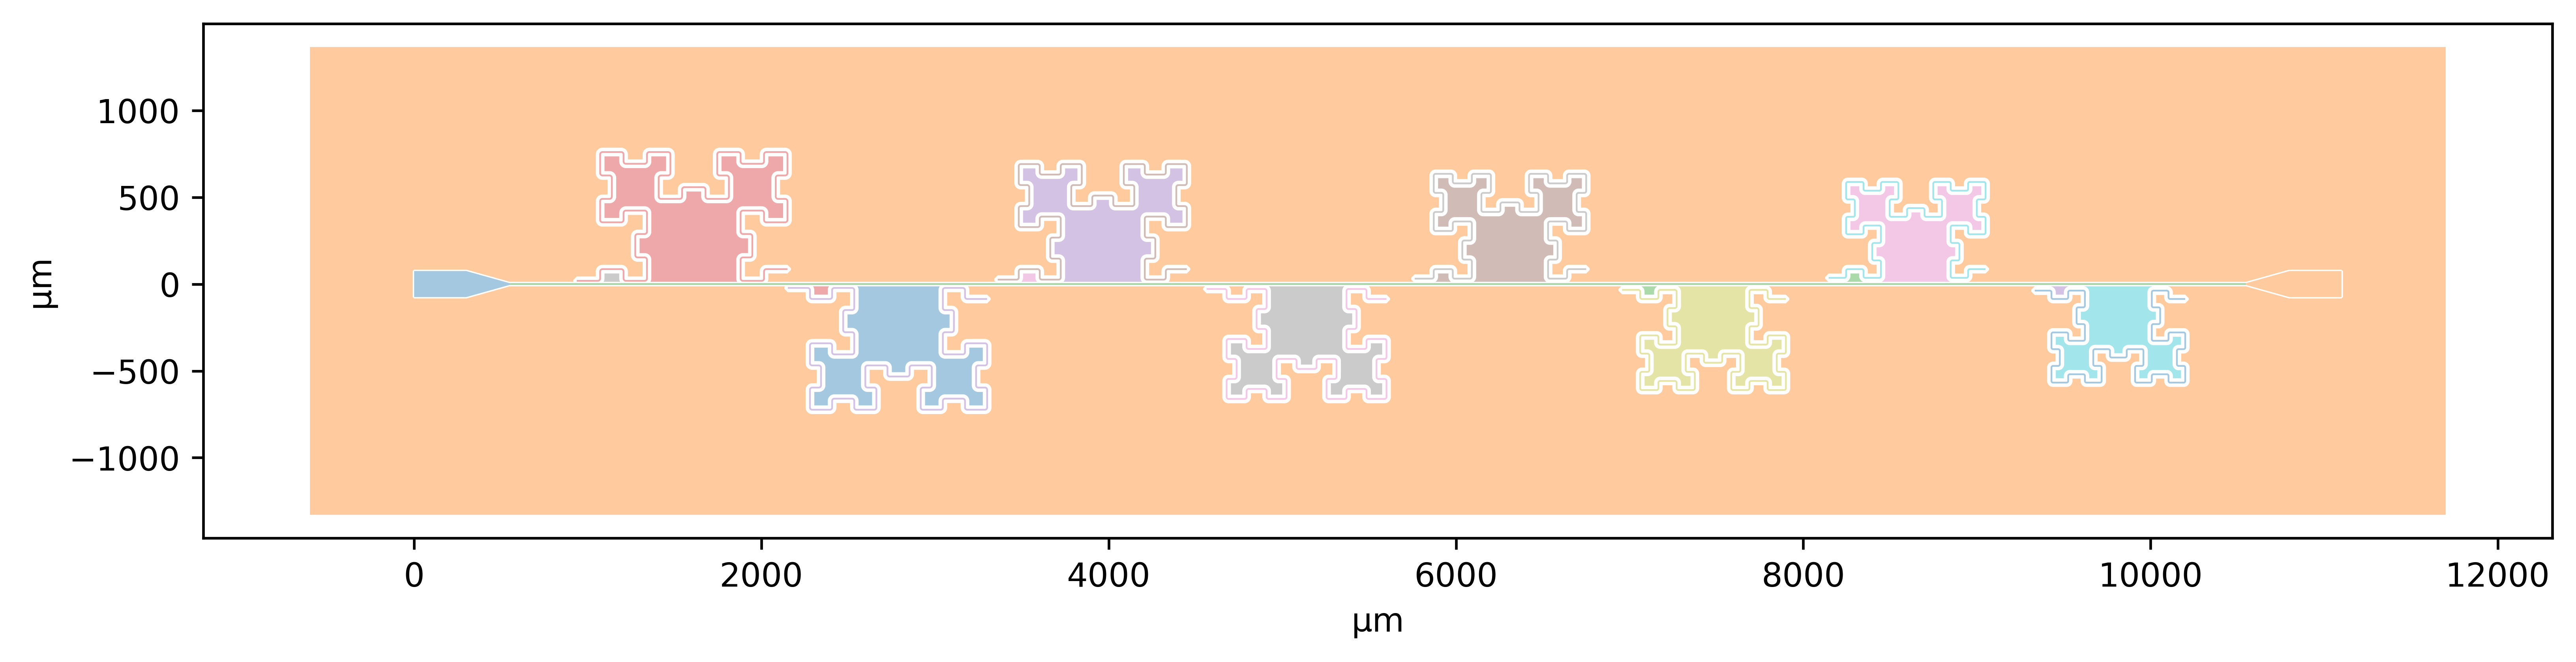


OASIS written to cpw_fibonacci_resonators_v5_control_knobs.oas



In [52]:
#!/usr/bin/env python3
"""
CPW Feed (10 000 µm) with 8 Rotated Fibonacci–Fractal λ/4 Metamaterial Resonators
(no IDCs) — Resonators placed 20 µm from the CPW feed line

Revision : G_noIDC_adjacent_offset20_control_knobs_v1
Author   : Onri Jay Benally / Modified with control knobs
Date     : 2025-06-05
───────────────────────────────────────────
Run locally or in Colab:

    pip install gdstk matplotlib
    python cpw_fibonacci_resonators_v5_control_knobs.py

Outputs:
    • Interactive preview window (Matplotlib)
    • cpw_fibonacci_resonators_v5_control_knobs.oas   (OASIS-v1.0 layout)
"""
# ───────────────────────────────────
# 0) Imports & Matplotlib style
# ───────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

# ───────────────────────────────────
# Control Knobs: Adjust these values to change fractal behavior
# ───────────────────────────────────
# Number of Fibonacci-word iterations (higher → more complex fractal)
FIB_ITER = 9                # integer: 1, 2, 3, …
# Fraction of step length used as bend radius in FlexPath (0 → sharp corners, up to 0.5 or more)
FRACTAL_FILLET_FACTOR = 0.2  # float: 0.0 to 1.0 (or higher for smoother arcs)

# ───────────────────────────────────
# 1) Technology & Electrical Design Parameters
# ───────────────────────────────────
tech = dict(
    # — CPW feed line —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=10000.0,          # µm   distance between launch-pad taper roots

    # — Fibonacci-fractal resonators —
    w_res=10.0,                # µm   resonator trace width
    g_res=8.0,                 # µm   keep-out gap (for cavity)
    fib_iter=FIB_ITER,         # iterations of Fibonacci word (from control knob)
    fractal_fillet_factor=FRACTAL_FILLET_FACTOR,  # bend radius factor (from control knob)
    d_feed_res=2.0,            # µm   (unused here; originally IDC gap)

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)

    # — Cavity & chip frame —
    cavity_margin=12.0,        # µm   clearance around each resonator (increased to ensure gaps)
    margin=600.0,              # µm   ground-to-edge clearance
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths for 5 → 7 GHz (8 resonators)
LQ_5GHz = 6000.0                              # µm quarter-wave at 5 GHz in substrate
freqs = np.linspace(5.0, 7.0, 8)              # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs       # µm per resonator

# ───────────────────────────────────
# 2) Build the Fibonacci-word unit polyline (no truncation)
# ───────────────────────────────────
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def fibonacci_word(n: int) -> str:
    """Return the n-th Fibonacci word (F₁="0", F₂="01", …)."""
    a, b = "0", "01"
    for _ in range(n - 1):
        a, b = b, b + a
    return b

# Compute the unit-step polyline for the chosen iteration
_FIB_WORD = fibonacci_word(tech["fib_iter"])
_unit_polyline = [np.array([0.0, 0.0])]
cur_dir = 0
for idx, ch in enumerate(_FIB_WORD):
    if ch == "1":
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
    else:  # ch == "0" ⇒ turn then step
        if idx % 2 == 0:
            cur_dir = (cur_dir + 1) % 4
        else:
            cur_dir = (cur_dir - 1) % 4
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
_unit_polyline = np.asarray(_unit_polyline)
_NUM_MOVES = len(_unit_polyline) - 1
_UNIT_WIDTH = _unit_polyline[:, 0].max() - _unit_polyline[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES  # dimensionless

# ───────────────────────────────────
# 3) Helper: quick preview
# ───────────────────────────────────

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:  # fallback for older gdstk versions
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# ───────────────────────────────────
# 4) Geometry utilities
# ───────────────────────────────────

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))


def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]


def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    """Linear taper from feed width to pad width followed by rectangular pad.
    direction = +1 extends towards +x, −1 towards −x."""
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]

    x_feed      = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end   = x_taper_end + direction * pad_len

    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

# ───────────────────────────────────
# 5) Build one Fibonacci-fractal resonator (rotated left 90°)
# ───────────────────────────────────

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    """Rotate points left (CCW) by 90° about origin."""
    return np.column_stack((-pts[:, 1], pts[:, 0]))


def build_fibonacci_resonator(origin, lambda_q, p, upward=True):
    """
    Return a list of polygons for one Fibonacci resonator (rotated left 90°).
    The step size is chosen so that total path length ≈ λ/4 (lambda_q).
    """
    step = lambda_q / _NUM_MOVES  # each forward-move length (µm)
    pts = _unit_polyline * step
    pts = rotate_left_90(pts)  # rotation

    if not upward:
        pts = pts.copy()
        pts[:, 1] *= -1  # mirror across feed centreline

    # translate so first point sits at 'origin'
    pts += np.asarray(origin) - pts[0]

    # calculate bend radius from control knob (fraction of step)
    bend_radius = step * p.get("fractal_fillet_factor", 0.5)
    fp = gdstk.FlexPath(pts.tolist(), p["w_res"], bend_radius=bend_radius, simple_path=True)
    return fp.to_polygons()

# ───────────────────────────────────
# 6) Assemble the full chip (no IDCs, resonators 20 µm offset)
# ───────────────────────────────────

def build_full_chip(p):
    lib  = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []           # all metal polygons
    cavities   = []           # ground cut-outs around resonators

    # — Pads + feed line —
    feed_x0   = p["pad_len"] + p["pad_taper_len"]
    pad_left  = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])

    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    # — Determine resonator pitch so array fits within feed length —
    inset = 400.0  # µm inset on each side (in front of pads)
    usable_length = p["feed_len"] - 2 * inset
    pitch = usable_length / len(lambda_quarters)  # µm between resonator anchors

    start_x = feed_x0 + inset

    for idx, lq in enumerate(lambda_quarters):
        upward = (idx % 2 == 0)
        # 1200 µm horizontal shift from pad inset
        anchor_x = start_x + idx * pitch + 1200.0

        # Compute “step” for this resonator, then its bounding height:
        step = lq / _NUM_MOVES
        bounding_height = _UNIT_WIDTH * step

        # Place the fractal so its bottom (or top) has a 70 µm gap from CPW conductor:
        #   half-feed + g_feed + 70 + half-resonator-width
        y_off = p["w_feed"]/2 + p["g_feed"] + 70.0 + p["w_res"]/2
        anchor_y = y_off if upward else -y_off

        # (a) Fibonacci resonator rotated 90°
        res_polys = build_fibonacci_resonator((anchor_x, anchor_y), lq, p, upward)
        cell.add(*res_polys)
        conductors.extend(res_polys)

        # (b) Carve a cavity around that fractal with increased margin
        res_union = gdstk.boolean(res_polys, [], "or")
        cav = gdstk.offset(res_union, p["g_res"] + p["cavity_margin"], join="round")
        cavities.extend(cav)

    # — Autocarved ground plane with warnings suppressed —
    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    # Construct frame coordinates
    min_x = min(poly.points[:, 0].min() for poly in conductors)
    min_y = min(poly.points[:, 1].min() for poly in conductors)
    max_x = max(poly.points[:, 0].max() for poly in conductors)
    max_y = max(poly.points[:, 1].max() for poly in conductors)

    frame = rect(min_x - p["margin"], min_y - p["margin"], max_x + p["margin"], max_y + p["margin"])

    if keepout:  # carve ground only if keepout valid
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

# ───────────────────────────────────
# 7) Main
# ───────────────────────────────────
if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_fibonacci_resonators_v5_control_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")

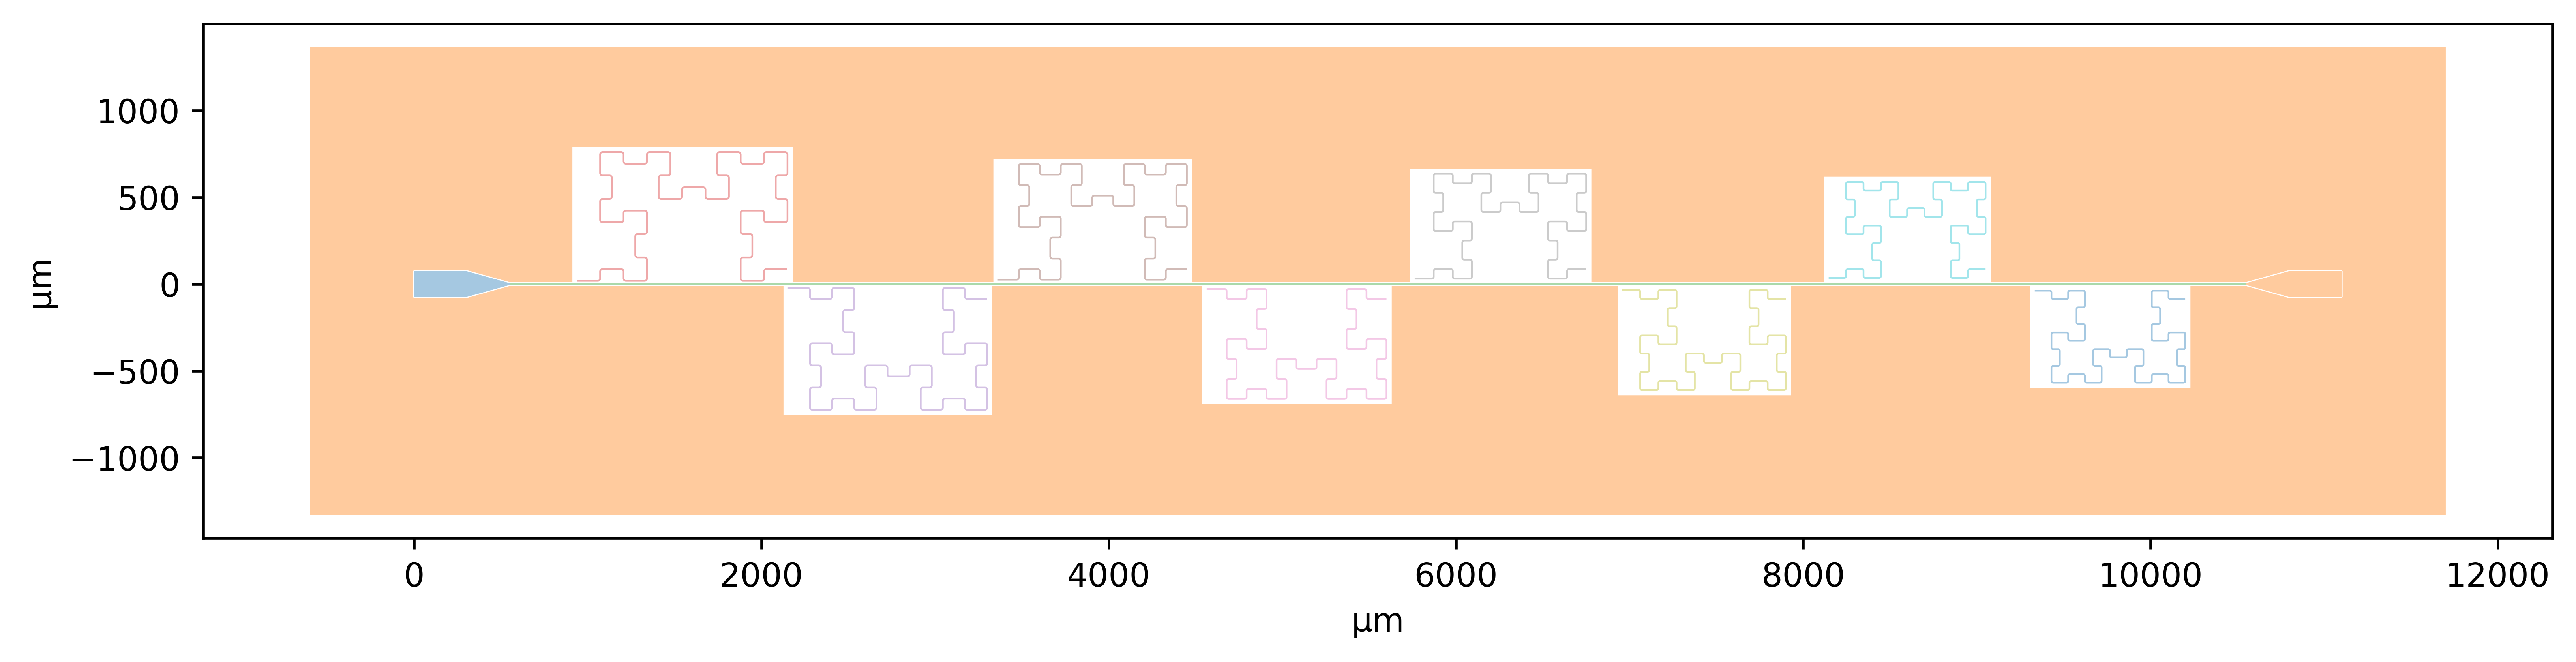


OASIS written to cpw_fibonacci_resonators_v7_square_cavities_control_knobs.oas



In [54]:
#!/usr/bin/env python3
"""
CPW Feed (10 000 µm) with 8 Rotated Fibonacci–Fractal λ/4 Metamaterial Resonators
(no IDCs) — Resonators placed 20 µm from the CPW feed line

Revision : G_noIDC_adjacent_offset20_square_cavities_control_knobs_v1
Author   : Onri Jay Benally / Modified with control knobs
Date     : 2025-06-06
───────────────────────────────────────────
Run locally or in Colab:

    pip install gdstk matplotlib
    python cpw_fibonacci_resonators_v7_control_knobs.py

Outputs:
    • Interactive preview window (Matplotlib)
    • cpw_fibonacci_resonators_v7_square_cavities_control_knobs.oas   (OASIS-v1.0 layout)
"""
# ───────────────────────────────────
# 0) Imports & Matplotlib style
# ───────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

# ───────────────────────────────────
# Control Knobs: Adjust these values to change fractal behavior
# ───────────────────────────────────
# Number of Fibonacci-word iterations (higher → more complex fractal)
FIB_ITER = 9                # integer: 1, 2, 3, …
# Fraction of step length used as bend radius in FlexPath (0 → sharp corners, up to 0.5 or more)
FRACTAL_FILLET_FACTOR = 0.2  # float: 0.0 to 1.0 (or higher for smoother arcs)

# ───────────────────────────────────
# 1) Technology & Electrical Design Parameters
# ───────────────────────────────────
tech = dict(
    # — CPW feed line —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=10000.0,          # µm   distance between launch-pad taper roots

    # — Fibonacci-fractal resonators —
    w_res=10.0,                # µm   resonator trace width
    g_res=6.0,                 # µm   keep-out gap (unused)
    fib_iter=FIB_ITER,         # iterations of Fibonacci word (from control knob)
    fractal_fillet_factor=FRACTAL_FILLET_FACTOR,  # bend radius factor (from control knob)
    d_feed_res=2.0,            # µm   (unused)

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)

    # — Square cavity margin —
    sq_margin=50.0,            # µm   margin around each fractal for square cavity
    fillet_radius=25.0,        # µm   radius for filleted cavity corners

    # — Cavity & chip frame —
    cavity_margin=12.0,        # µm   clearance around each resonator for precise cavity
    margin=600.0,              # µm   ground-to-edge clearance
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths for 5 → 7 GHz (8 resonators)
LQ_5GHz = 6000.0                              # µm quarter-wave at 5 GHz in substrate
freqs = np.linspace(5.0, 7.0, 8)              # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs       # µm per resonator

# ───────────────────────────────────
# 2) Build the Fibonacci-word unit polyline (no truncation)
# ───────────────────────────────────
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def fibonacci_word(n: int) -> str:
    """Return the n-th Fibonacci word (F₁='0', F₂='01', …)."""
    a, b = "0", "01"
    for _ in range(n - 1):
        a, b = b, b + a
    return b

# Compute the unit-step polyline for the chosen iteration
_FIB_WORD = fibonacci_word(tech["fib_iter"])
_unit_polyline = [np.array([0.0, 0.0])]
cur_dir = 0
for idx, ch in enumerate(_FIB_WORD):
    if ch == "1":
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
    else:  # ch == '0' ⇒ turn then step
        cur_dir = (cur_dir + (1 if idx % 2 == 0 else -1)) % 4
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
_unit_polyline = np.asarray(_unit_polyline)
_NUM_MOVES = len(_unit_polyline) - 1
_UNIT_WIDTH = _unit_polyline[:, 0].max() - _unit_polyline[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES  # dimensionless

# ───────────────────────────────────
# 3) Helper: quick preview
# ───────────────────────────────────

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# ───────────────────────────────────
# 4) Geometry utilities
# ───────────────────────────────────

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))


def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]


def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    """Linear taper from feed width to pad width followed by rectangular pad."""
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]
    x_feed = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end = x_taper_end + direction * pad_len
    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

# ───────────────────────────────────
# 5) Build one Fibonacci-fractal resonator (rotated left 90°)
# ───────────────────────────────────

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    """Rotate points left (CCW) by 90° about origin."""
    return np.column_stack((-pts[:, 1], pts[:, 0]))


def build_fibonacci_resonator(origin, lambda_q, p, upward=True):
    """
    Return a list of polygons for one Fibonacci resonator (rotated left 90°).
    """
    step = lambda_q / _NUM_MOVES
    pts = _unit_polyline * step
    pts = rotate_left_90(pts)
    if not upward:
        pts = pts.copy()
        pts[:, 1] *= -1
    pts += np.asarray(origin) - pts[0]
    # use control knob for bend radius
    bend_radius = step * p.get("fractal_fillet_factor", 0.5)
    fp = gdstk.FlexPath(
        pts.tolist(), p["w_res"], bend_radius=bend_radius, simple_path=True
    )
    return fp.to_polygons()

# ───────────────────────────────────
# 6) Assemble the full chip with large filleted square cavities
# ───────────────────────────────────

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []
    cavities = []

    # Pads + feed line
    feed_x0 = p["pad_len"] + p["pad_taper_len"]
    pad_left = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    # Resonator pitch
    inset = 400.0
    usable_length = p["feed_len"] - 2 * inset
    pitch = usable_length / len(lambda_quarters)
    start_x = feed_x0 + inset

    for idx, lq in enumerate(lambda_quarters):
        upward = (idx % 2 == 0)
        anchor_x = start_x + idx * pitch + 1200.0
        step = lq / _NUM_MOVES
        y_off = p["w_feed"]/2 + p["g_feed"] + 70.0 + p["w_res"]/2
        anchor_y = y_off if upward else -y_off

        # Build fractal
        res_polys = build_fibonacci_resonator((anchor_x, anchor_y), lq, p, upward)
        cell.add(*res_polys)
        conductors.extend(res_polys)

        # Compute union of fractal polygons
        res_union = gdstk.boolean(res_polys, [], "or")
        # Compute bounding box of res_union
        xs = np.concatenate([poly.points[:, 0] for poly in res_union])
        ys = np.concatenate([poly.points[:, 1] for poly in res_union])
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        # Expand by square margin
        sq_min_x = min_x - p["sq_margin"]
        sq_min_y = min_y - p["sq_margin"]
        sq_max_x = max_x + p["sq_margin"]
        sq_max_y = max_y + p["sq_margin"]
        # Create rectangle for square cavity
        sq_rect = gdstk.rectangle((sq_min_x, sq_min_y), (sq_max_x, sq_max_y))
        # Round corners by offsetting inward with fillet radius
        # Equivalent to filleting: offset inward by -(fillet_radius)
        filleted_sq = gdstk.offset(sq_rect, -p["fillet_radius"], join="round")
        cavities.extend(filleted_sq)

    # Autocarved ground plane
    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    # Frame
    xs_all = np.concatenate([poly.points[:, 0] for poly in conductors])
    ys_all = np.concatenate([poly.points[:, 1] for poly in conductors])
    frame = rect(xs_all.min() - p["margin"], ys_all.min() - p["margin"],
                 xs_all.max() + p["margin"], ys_all.max() + p["margin"] )
    if keepout:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

# ───────────────────────────────────
# 7) Main
# ───────────────────────────────────
if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_fibonacci_resonators_v7_square_cavities_control_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")

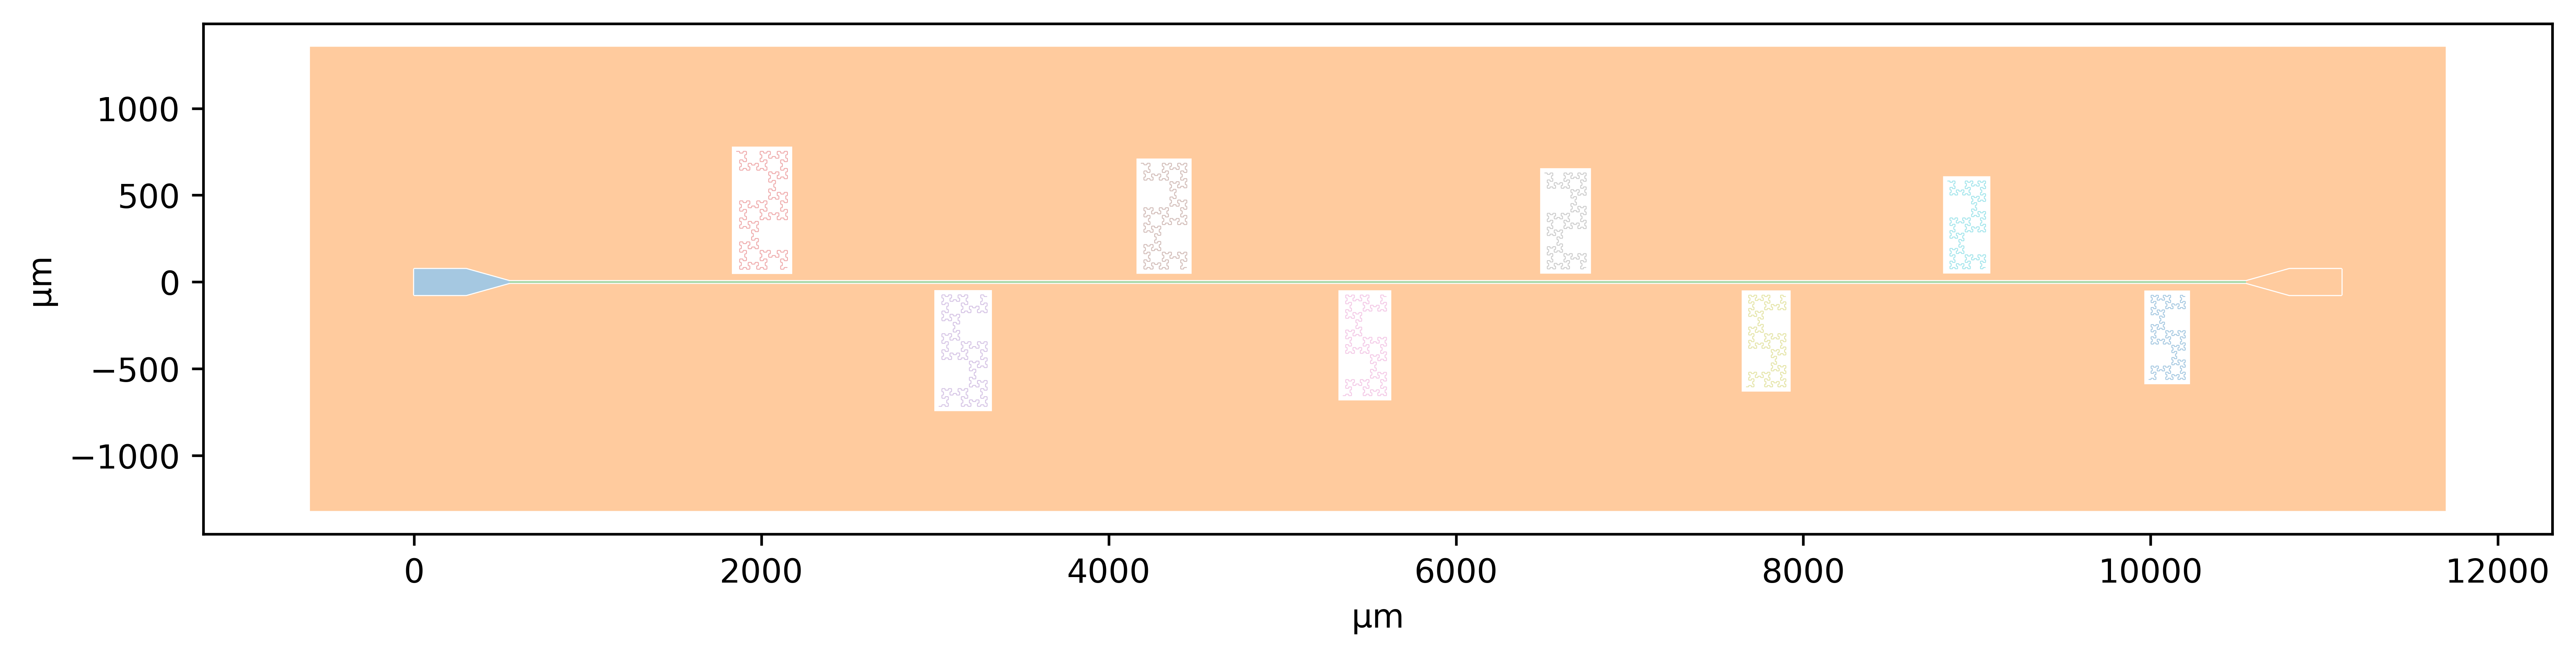


OASIS written to cpw_fibonacci_resonators_v12_square_cavities_control_knobs.oas



In [69]:
#!/usr/bin/env python3
"""
CPW Feed (10 000 µm) with 8 Rotated Fibonacci–Fractal λ/4 Metamaterial Resonators
(no IDCs) — Resonators placed 20 µm from the CPW feed line

Revision : G_noIDC_adjacent_offset20_square_cavities_control_knobs_v1
Author   : Onri Jay Benally / Modified with control knobs
Date     : 2025-06-06
───────────────────────────────────────────
Run locally or in Colab:

    pip install gdstk matplotlib
    python cpw_fibonacci_resonators_v7_control_knobs.py

Outputs:
    • Interactive preview window (Matplotlib)
    • cpw_fibonacci_resonators_v7_square_cavities_control_knobs.oas   (OASIS-v1.0 layout)
"""
# ───────────────────────────────────
# 0) Imports & Matplotlib style
# ───────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

# ───────────────────────────────────
# Control Knobs: Adjust these values to change fractal behavior
# ───────────────────────────────────
# Number of Fibonacci-word iterations (higher → more complex fractal)
FIB_ITER = 13                # integer: 1, 2, 3, …
# Fraction of step length used as bend radius in FlexPath (0 → sharp corners, up to 0.5 or more)
FRACTAL_FILLET_FACTOR = 0.4  # float: 0.0 to 1.0 (or higher for smoother arcs)

# ───────────────────────────────────
# 1) Technology & Electrical Design Parameters
# ───────────────────────────────────
tech = dict(
    # — CPW feed line —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=10000.0,          # µm   distance between launch-pad taper roots

    # — Fibonacci-fractal resonators —
    w_res=5.0,                # µm   resonator trace width
    g_res=6.0,                 # µm   keep-out gap (unused)
    fib_iter=FIB_ITER,         # iterations of Fibonacci word (from control knob)
    fractal_fillet_factor=FRACTAL_FILLET_FACTOR,  # bend radius factor (from control knob)
    d_feed_res=2.0,            # µm   (unused)

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)

    # — Square cavity margin —
    sq_margin=50.0,            # µm   margin around each fractal for square cavity
    fillet_radius=25.0,        # µm   radius for filleted cavity corners

    # — Cavity & chip frame —
    cavity_margin=12.0,        # µm   clearance around each resonator for precise cavity
    margin=600.0,              # µm   ground-to-edge clearance
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths for 5 → 7 GHz (8 resonators)
LQ_5GHz = 6000.0                              # µm quarter-wave at 5 GHz in substrate
freqs = np.linspace(5.0, 7.0, 8)              # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs       # µm per resonator

# ───────────────────────────────────
# 2) Build the Fibonacci-word unit polyline (no truncation)
# ───────────────────────────────────
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def fibonacci_word(n: int) -> str:
    """Return the n-th Fibonacci word (F₁='0', F₂='01', …)."""
    a, b = "0", "01"
    for _ in range(n - 1):
        a, b = b, b + a
    return b

# Compute the unit-step polyline for the chosen iteration
_FIB_WORD = fibonacci_word(tech["fib_iter"])
_unit_polyline = [np.array([0.0, 0.0])]
cur_dir = 0
for idx, ch in enumerate(_FIB_WORD):
    if ch == "1":
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
    else:  # ch == '0' ⇒ turn then step
        cur_dir = (cur_dir + (1 if idx % 2 == 0 else -1)) % 4
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
_unit_polyline = np.asarray(_unit_polyline)
_NUM_MOVES = len(_unit_polyline) - 1
_UNIT_WIDTH = _unit_polyline[:, 0].max() - _unit_polyline[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES  # dimensionless

# ───────────────────────────────────
# 3) Helper: quick preview
# ───────────────────────────────────

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# ───────────────────────────────────
# 4) Geometry utilities
# ───────────────────────────────────

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))


def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]


def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    """Linear taper from feed width to pad width followed by rectangular pad."""
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]
    x_feed = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end = x_taper_end + direction * pad_len
    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

# ───────────────────────────────────
# 5) Build one Fibonacci-fractal resonator (rotated left 90°)
# ───────────────────────────────────

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    """Rotate points left (CCW) by 90° about origin."""
    return np.column_stack((-pts[:, 1], pts[:, 0]))


def build_fibonacci_resonator(origin, lambda_q, p, upward=True):
    """
    Return a list of polygons for one Fibonacci resonator (rotated left 90°).
    """
    step = lambda_q / _NUM_MOVES
    pts = _unit_polyline * step
    pts = rotate_left_90(pts)
    if not upward:
        pts = pts.copy()
        pts[:, 1] *= -1
    pts += np.asarray(origin) - pts[0]
    # use control knob for bend radius
    bend_radius = step * p.get("fractal_fillet_factor", 0.5)
    fp = gdstk.FlexPath(
        pts.tolist(), p["w_res"], bend_radius=bend_radius, simple_path=True
    )
    return fp.to_polygons()

# ───────────────────────────────────
# 6) Assemble the full chip with large filleted square cavities
# ───────────────────────────────────

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []
    cavities = []

    # Pads + feed line
    feed_x0 = p["pad_len"] + p["pad_taper_len"]
    pad_left = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    # Resonator pitch
    inset = 400.0
    usable_length = p["feed_len"] - 2 * inset
    pitch = usable_length / len(lambda_quarters)
    start_x = feed_x0 + inset

    for idx, lq in enumerate(lambda_quarters):
        upward = (idx % 2 == 0)
        anchor_x = start_x + idx * pitch + 1200.0
        step = lq / _NUM_MOVES
        y_off = p["w_feed"]/2 + p["g_feed"] + 70.0 + p["w_res"]/2
        anchor_y = y_off if upward else -y_off

        # Build fractal
        res_polys = build_fibonacci_resonator((anchor_x, anchor_y), lq, p, upward)
        cell.add(*res_polys)
        conductors.extend(res_polys)

        # Compute union of fractal polygons
        res_union = gdstk.boolean(res_polys, [], "or")
        # Compute bounding box of res_union
        xs = np.concatenate([poly.points[:, 0] for poly in res_union])
        ys = np.concatenate([poly.points[:, 1] for poly in res_union])
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        # Expand by square margin
        sq_min_x = min_x - p["sq_margin"]
        sq_min_y = min_y - p["sq_margin"]
        sq_max_x = max_x + p["sq_margin"]
        sq_max_y = max_y + p["sq_margin"]
        # Create rectangle for square cavity
        sq_rect = gdstk.rectangle((sq_min_x, sq_min_y), (sq_max_x, sq_max_y))
        # Round corners by offsetting inward with fillet radius
        # Equivalent to filleting: offset inward by -(fillet_radius)
        filleted_sq = gdstk.offset(sq_rect, -p["fillet_radius"], join="round")
        cavities.extend(filleted_sq)

    # Autocarved ground plane
    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    # Frame
    xs_all = np.concatenate([poly.points[:, 0] for poly in conductors])
    ys_all = np.concatenate([poly.points[:, 1] for poly in conductors])
    frame = rect(xs_all.min() - p["margin"], ys_all.min() - p["margin"],
                 xs_all.max() + p["margin"], ys_all.max() + p["margin"] )
    if keepout:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

# ───────────────────────────────────
# 7) Main
# ───────────────────────────────────
if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_fibonacci_resonators_v12_square_cavities_control_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")

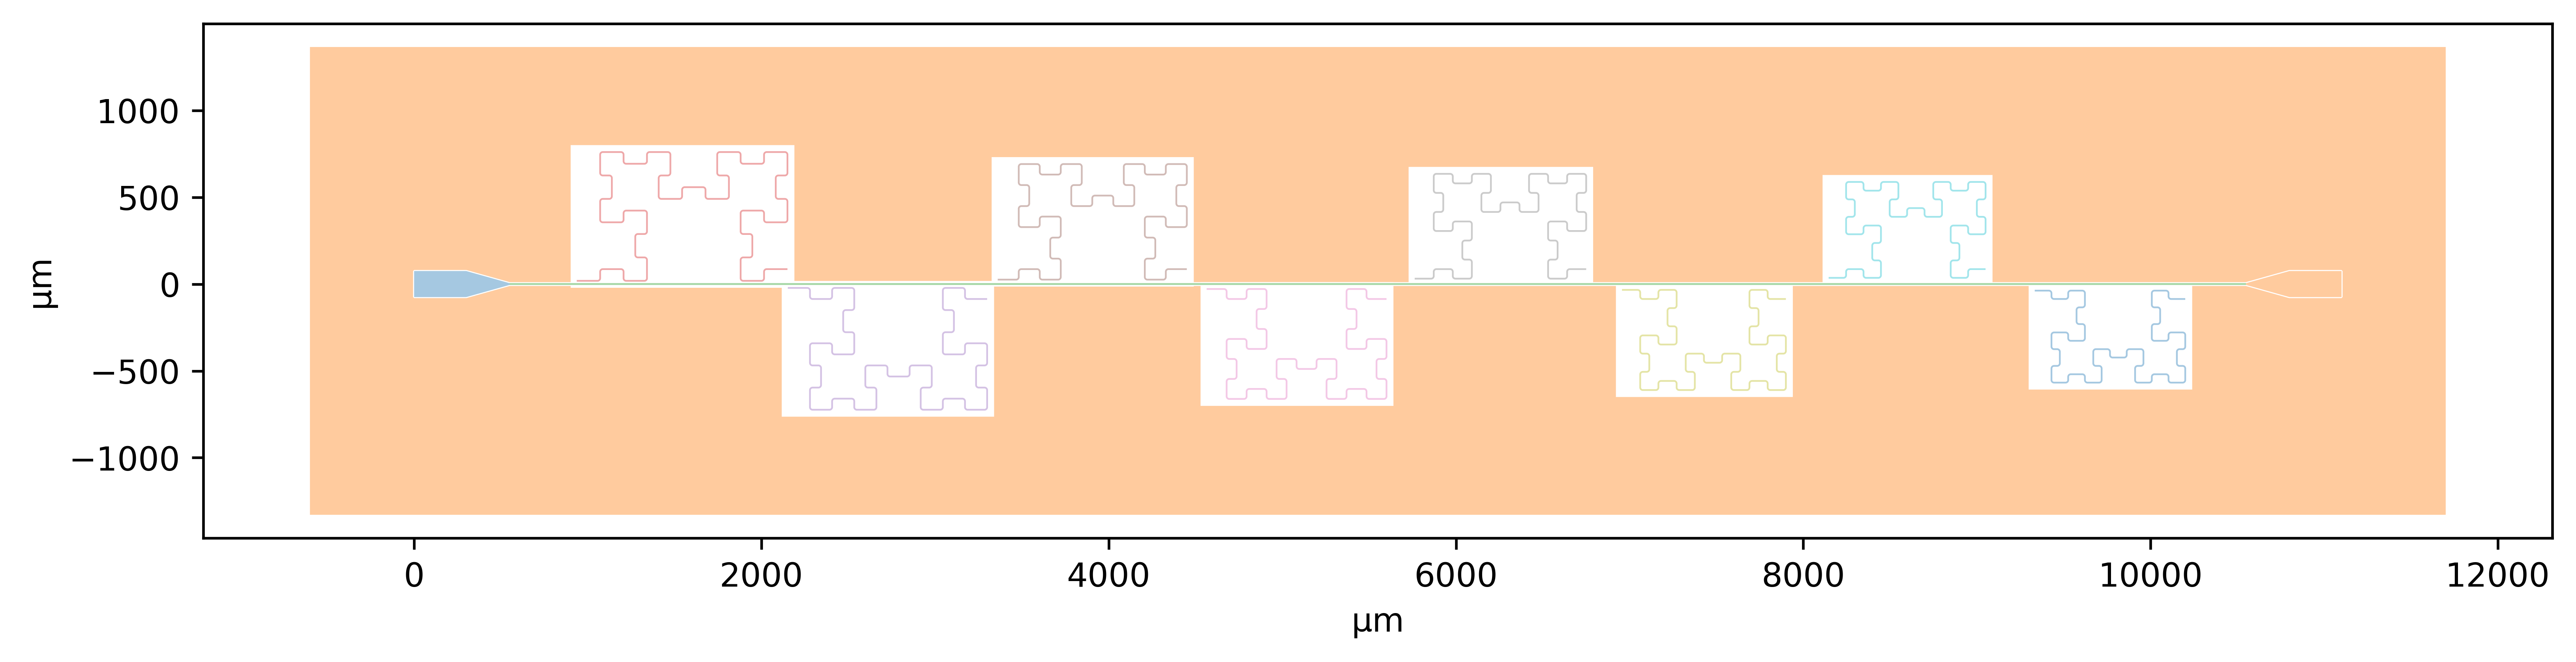


OASIS written to cpw_fibonacci_resonators_v7_square_cavities_with_knobs.oas



In [35]:
# Control Knobs (modify these to adjust fractal fillets and iteration)
# ─────────────────────────────────────────────────────────────
# Number of Fibonacci iterations (higher → more complex fractal)
FIB_ITER = 9  # e.g., set to 8, 9, 10, etc.

# Fillet radius (µm) for rounding each fractal corner
FRACTAL_FILLET_RADIUS = 15.0  # e.g., set to 0 for sharp, up to step length for full radius

# ─────────────────────────────────────────────────────────────
# Remaining imports and code follow below (use FIB_ITER and FRACTAL_FILLET_RADIUS)
# ─────────────────────────────────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

tech = dict(
    # — CPW feed line —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=10000.0,          # µm   distance between launch-pad taper roots

    # — Fibonacci-fractal resonators —
    w_res=10.0,                # µm   resonator trace width
    g_res=6.0,                 # µm   keep-out gap (unused)
    fib_iter=FIB_ITER,         # iterations of Fibonacci word
    d_feed_res=2.0,            # µm   (unused)

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)

    # — Square cavity margin —
    sq_margin=50.0,            # µm   margin around each fractal for square cavity
    fillet_radius=FRACTAL_FILLET_RADIUS,  # µm   radius for filleted cavity corners

    # — Cavity & chip frame —
    cavity_margin=12.0,        # µm   clearance around each resonator for precise cavity
    margin=600.0,              # µm   ground-to-edge clearance
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths for 5 → 7 GHz (8 resonators)
LQ_5GHz = 6000.0                              # µm quarter-wave at 5 GHz in substrate
freqs = np.linspace(5.0, 7.0, 8)              # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs       # µm per resonator

# Build Fibonacci-word with control knob fib_iter
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def fibonacci_word(n: int) -> str:
    a, b = "0", "01"
    for _ in range(n - 1):
        a, b = b, b + a
    return b

_FIB_WORD = fibonacci_word(tech["fib_iter"])
_unit_polyline = [np.array([0.0, 0.0])]
cur_dir = 0
for idx, ch in enumerate(_FIB_WORD):
    if ch == "1":
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
    else:
        cur_dir = (cur_dir + (1 if idx % 2 == 0 else -1)) % 4
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
_unit_polyline = np.asarray(_unit_polyline)
_NUM_MOVES = len(_unit_polyline) - 1
_UNIT_WIDTH = _unit_polyline[:, 0].max() - _unit_polyline[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES

mpl.rcParams["figure.dpi"] = 600

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))

def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]

def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]
    x_feed = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end = x_taper_end + direction * pad_len
    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    return np.column_stack((-pts[:, 1], pts[:, 0]))

def build_fibonacci_resonator(origin, lambda_q, p, upward=True):
    step = lambda_q / _NUM_MOVES
    pts = _unit_polyline * step
    pts = rotate_left_90(pts)
    if not upward:
        pts = pts.copy()
        pts[:, 1] *= -1
    pts += np.asarray(origin) - pts[0]
    fp = gdstk.FlexPath(
        pts.tolist(), p["w_res"], bend_radius=p["fillet_radius"], simple_path=False
    )
    return fp.to_polygons()

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []
    cavities = []

    feed_x0 = p["pad_len"] + p["pad_taper_len"]
    pad_left = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    inset = 400.0
    usable_length = p["feed_len"] - 2 * inset
    pitch = usable_length / len(lambda_quarters)
    start_x = feed_x0 + inset

    for idx, lq in enumerate(lambda_quarters):
        upward = (idx % 2 == 0)
        anchor_x = start_x + idx * pitch + 1200.0
        step = lq / _NUM_MOVES
        y_off = p["w_feed"]/2 + p["g_feed"] + 70.0 + p["w_res"]/2
        anchor_y = y_off if upward else -y_off

        res_polys = build_fibonacci_resonator((anchor_x, anchor_y), lq, p, upward)
        cell.add(*res_polys)
        conductors.extend(res_polys)

        res_union = gdstk.boolean(res_polys, [], "or")
        xs = np.concatenate([poly.points[:, 0] for poly in res_union])
        ys = np.concatenate([poly.points[:, 1] for poly in res_union])
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        sq_min_x = min_x - p["sq_margin"]
        sq_min_y = min_y - p["sq_margin"]
        sq_max_x = max_x + p["sq_margin"]
        sq_max_y = max_y + p["sq_margin"]
        sq_rect = gdstk.rectangle((sq_min_x, sq_min_y), (sq_max_x, sq_max_y))
        filleted_sq = gdstk.offset(sq_rect, -p["fillet_radius"], join="round")
        cavities.extend(filleted_sq)

    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    xs_all = np.concatenate([poly.points[:, 0] for poly in conductors])
    ys_all = np.concatenate([poly.points[:, 1] for poly in conductors])
    frame = rect(xs_all.min() - p["margin"], ys_all.min() - p["margin"], xs_all.max() + p["margin"], ys_all.max() + p["margin"])
    if keepout:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_fibonacci_resonators_v7_square_cavities_with_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")

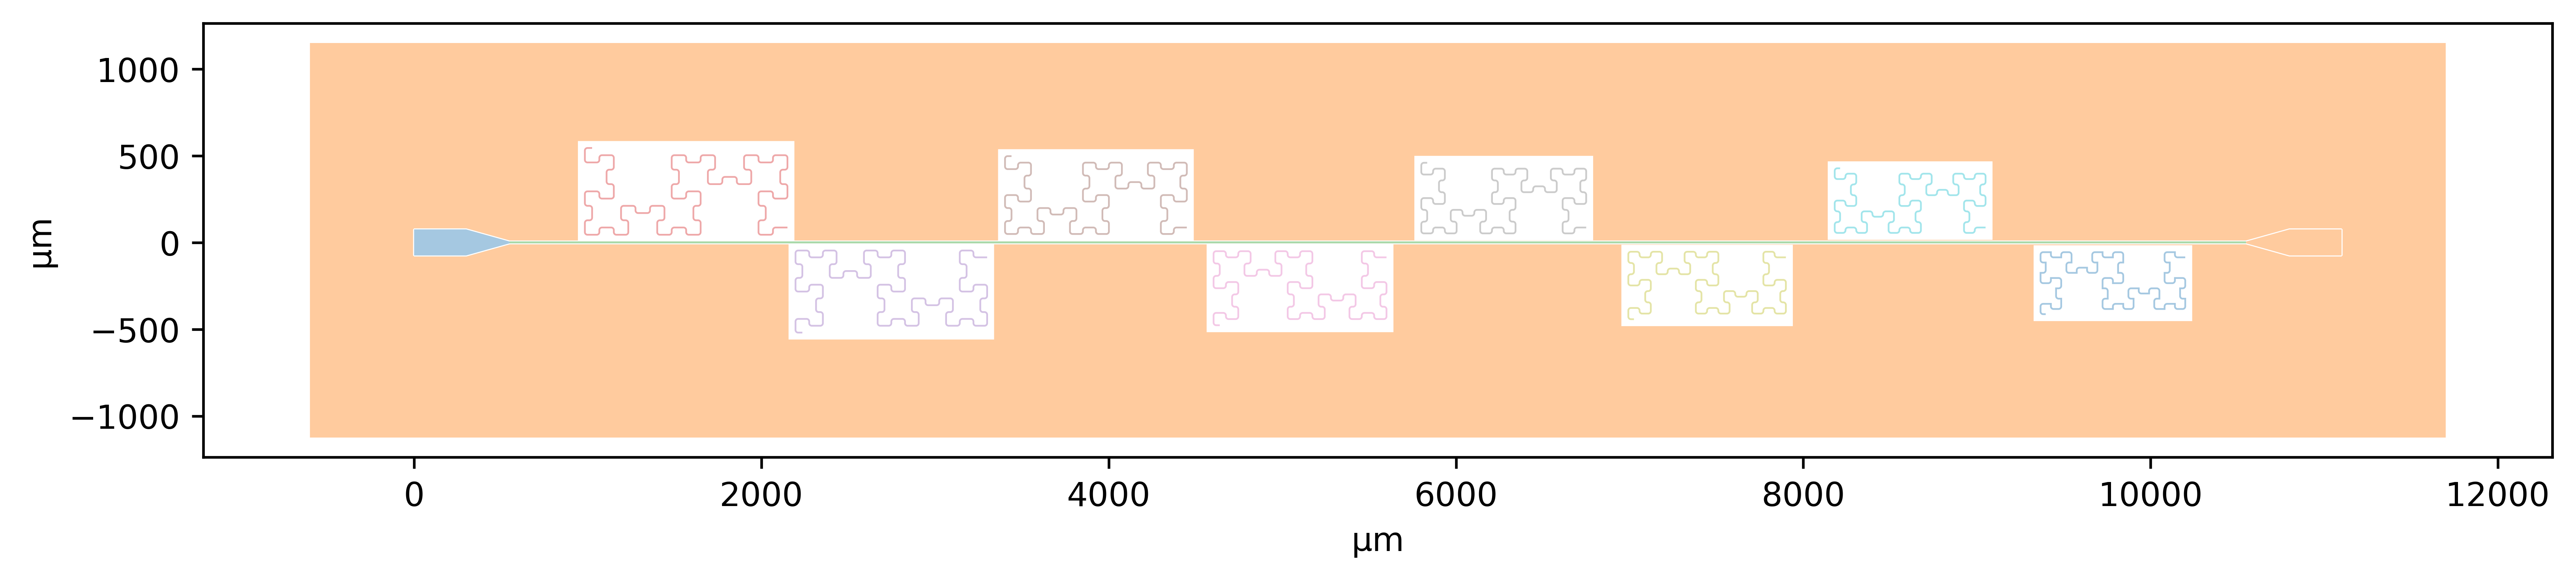


OASIS written to cpw_fibonacci_resonators_v7_square_cavities_with_knobs.oas



In [43]:
# Control Knobs (modify these to adjust fractal fillets and iteration)
# ─────────────────────────────────────────────────────────────
# Number of Fibonacci iterations (higher → more complex fractal)
FIB_ITER = 10  # e.g., set to 8, 9, 10, etc.

# Fillet radius (µm) for rounding each fractal corner
FRACTAL_FILLET_RADIUS = 15.0  # e.g., set to 0 for sharp, up to step length for full radius

# ─────────────────────────────────────────────────────────────
# Remaining imports and code follow below (use FIB_ITER and FRACTAL_FILLET_RADIUS)
# ─────────────────────────────────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

tech = dict(
    # — CPW feed line —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=10000.0,          # µm   distance between launch-pad taper roots

    # — Fibonacci-fractal resonators —
    w_res=10.0,                # µm   resonator trace width
    g_res=6.0,                 # µm   keep-out gap (unused)
    fib_iter=FIB_ITER,         # iterations of Fibonacci word
    d_feed_res=2.0,            # µm   (unused)

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)

    # — Square cavity margin —
    sq_margin=50.0,            # µm   margin around each fractal for square cavity
    fillet_radius=FRACTAL_FILLET_RADIUS,  # µm   radius for filleted cavity corners

    # — Cavity & chip frame —
    cavity_margin=12.0,        # µm   clearance around each resonator for precise cavity
    margin=600.0,              # µm   ground-to-edge clearance
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths for 5 → 7 GHz (8 resonators)
LQ_5GHz = 6000.0                              # µm quarter-wave at 5 GHz in substrate
freqs = np.linspace(5.0, 7.0, 8)              # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs       # µm per resonator

# Build Fibonacci-word with control knob fib_iter
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def fibonacci_word(n: int) -> str:
    a, b = "0", "01"
    for _ in range(n - 1):
        a, b = b, b + a
    return b

_FIB_WORD = fibonacci_word(tech["fib_iter"])
_unit_polyline = [np.array([0.0, 0.0])]
cur_dir = 0
for idx, ch in enumerate(_FIB_WORD):
    if ch == "1":
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
    else:
        cur_dir = (cur_dir + (1 if idx % 2 == 0 else -1)) % 4
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
_unit_polyline = np.asarray(_unit_polyline)
_NUM_MOVES = len(_unit_polyline) - 1
_UNIT_WIDTH = _unit_polyline[:, 0].max() - _unit_polyline[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES

mpl.rcParams["figure.dpi"] = 600

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))

def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]

def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]
    x_feed = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end = x_taper_end + direction * pad_len
    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    return np.column_stack((-pts[:, 1], pts[:, 0]))

def build_fibonacci_resonator(origin, lambda_q, p, upward=True):
    step = lambda_q / _NUM_MOVES
    pts = _unit_polyline * step
    pts = rotate_left_90(pts)
    if not upward:
        pts = pts.copy()
        pts[:, 1] *= -1
    pts += np.asarray(origin) - pts[0]
    fp = gdstk.FlexPath(
        pts.tolist(), p["w_res"], bend_radius=p["fillet_radius"], simple_path=False
    )
    return fp.to_polygons()

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []
    cavities = []

    feed_x0 = p["pad_len"] + p["pad_taper_len"]
    pad_left = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    inset = 400.0
    usable_length = p["feed_len"] - 2 * inset
    pitch = usable_length / len(lambda_quarters)
    start_x = feed_x0 + inset

    for idx, lq in enumerate(lambda_quarters):
        upward = (idx % 2 == 0)
        anchor_x = start_x + idx * pitch + 1200.0
        step = lq / _NUM_MOVES
        y_off = p["w_feed"]/2 + p["g_feed"] + 70.0 + p["w_res"]/2
        anchor_y = y_off if upward else -y_off

        res_polys = build_fibonacci_resonator((anchor_x, anchor_y), lq, p, upward)
        cell.add(*res_polys)
        conductors.extend(res_polys)

        res_union = gdstk.boolean(res_polys, [], "or")
        xs = np.concatenate([poly.points[:, 0] for poly in res_union])
        ys = np.concatenate([poly.points[:, 1] for poly in res_union])
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        sq_min_x = min_x - p["sq_margin"]
        sq_min_y = min_y - p["sq_margin"]
        sq_max_x = max_x + p["sq_margin"]
        sq_max_y = max_y + p["sq_margin"]
        sq_rect = gdstk.rectangle((sq_min_x, sq_min_y), (sq_max_x, sq_max_y))
        filleted_sq = gdstk.offset(sq_rect, -p["fillet_radius"], join="round")
        cavities.extend(filleted_sq)

    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    xs_all = np.concatenate([poly.points[:, 0] for poly in conductors])
    ys_all = np.concatenate([poly.points[:, 1] for poly in conductors])
    frame = rect(xs_all.min() - p["margin"], ys_all.min() - p["margin"], xs_all.max() + p["margin"], ys_all.max() + p["margin"])
    if keepout:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_fibonacci_resonators_v7_square_cavities_with_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")

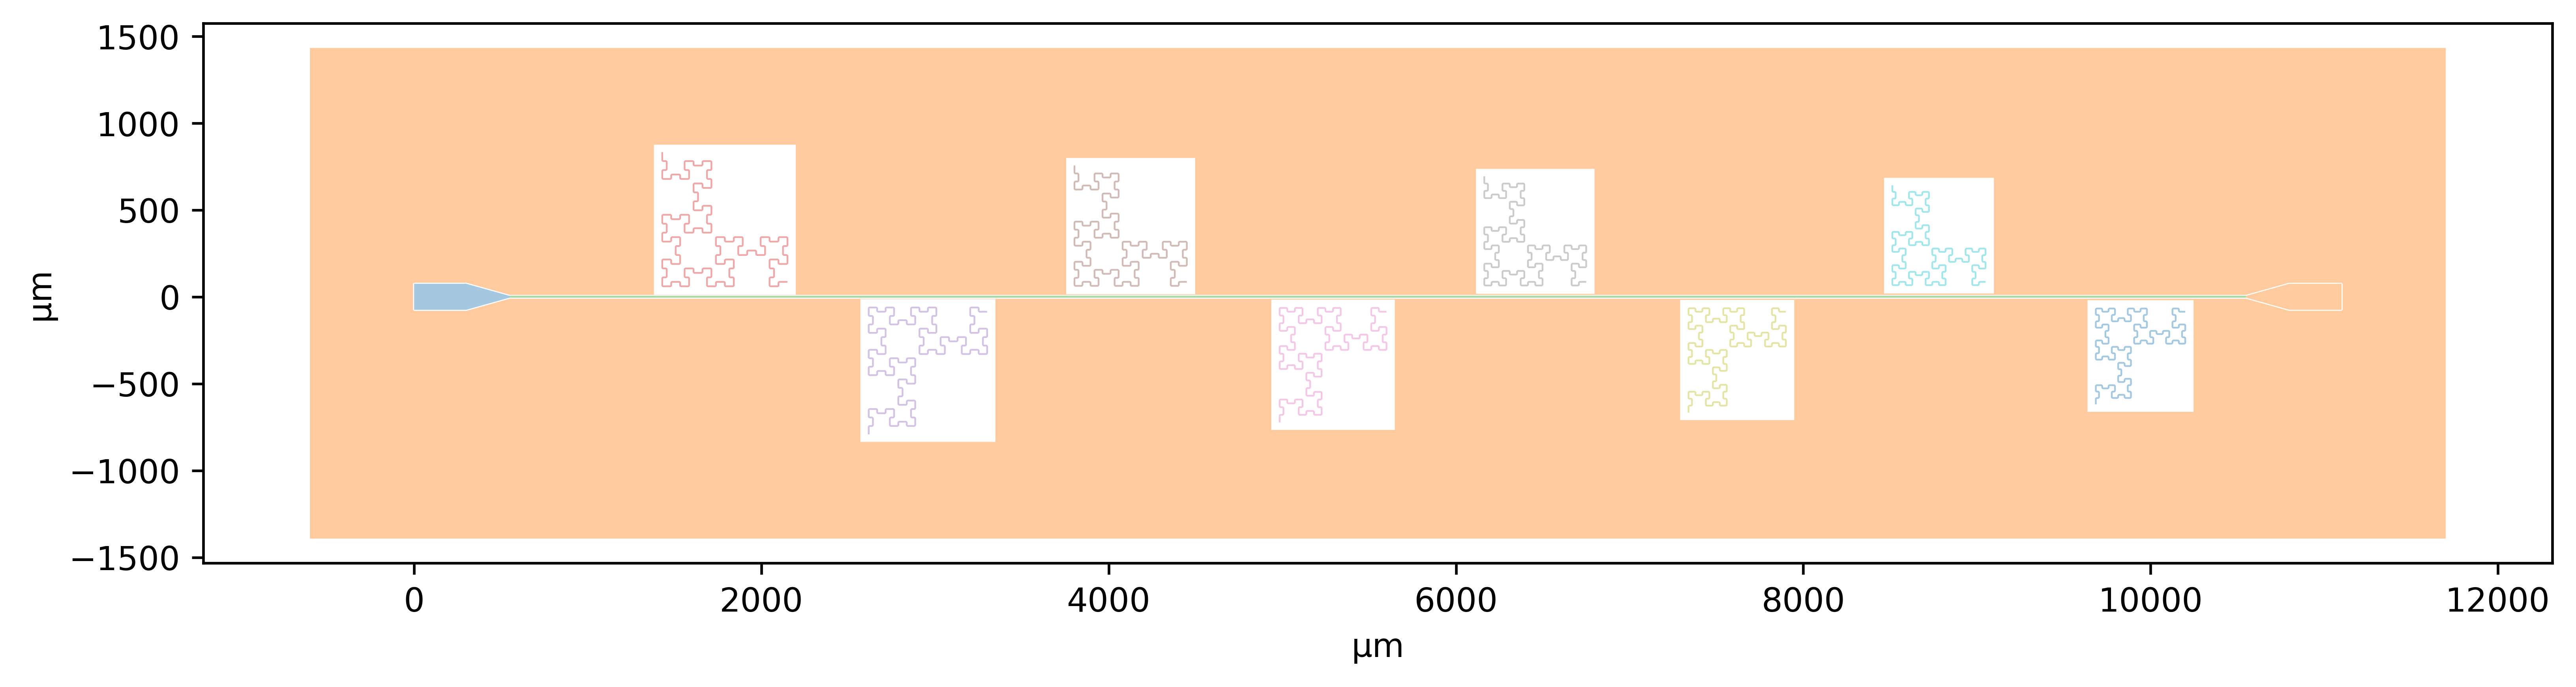


OASIS written to cpw_fibonacci_resonators_v7_square_cavities_with_knobs.oas



In [50]:
# Control Knobs (modify these to adjust fractal fillets and iteration)
# ─────────────────────────────────────────────────────────────
# Number of Fibonacci iterations (higher → more complex fractal)
FIB_ITER = 11  # e.g., set to 8, 9, 10, etc.

# Fillet radius (µm) for rounding each fractal corner
FRACTAL_FILLET_RADIUS = 7.0  # e.g., set to 0 for sharp, up to step length for full radius

# ─────────────────────────────────────────────────────────────
# Remaining imports and code follow below (use FIB_ITER and FRACTAL_FILLET_RADIUS)
# ─────────────────────────────────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

tech = dict(
    # — CPW feed line —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=10000.0,          # µm   distance between launch-pad taper roots

    # — Fibonacci-fractal resonators —
    w_res=10.0,                # µm   resonator trace width
    g_res=6.0,                 # µm   keep-out gap (unused)
    fib_iter=FIB_ITER,         # iterations of Fibonacci word
    d_feed_res=2.0,            # µm   (unused)

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)

    # — Square cavity margin —
    sq_margin=50.0,            # µm   margin around each fractal for square cavity
    fillet_radius=FRACTAL_FILLET_RADIUS,  # µm   radius for filleted cavity corners

    # — Cavity & chip frame —
    cavity_margin=12.0,        # µm   clearance around each resonator for precise cavity
    margin=600.0,              # µm   ground-to-edge clearance
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths for 5 → 7 GHz (8 resonators)
LQ_5GHz = 6000.0                              # µm quarter-wave at 5 GHz in substrate
freqs = np.linspace(5.0, 7.0, 8)              # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs       # µm per resonator

# Build Fibonacci-word with control knob fib_iter
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def fibonacci_word(n: int) -> str:
    a, b = "0", "01"
    for _ in range(n - 1):
        a, b = b, b + a
    return b

_FIB_WORD = fibonacci_word(tech["fib_iter"])
_unit_polyline = [np.array([0.0, 0.0])]
cur_dir = 0
for idx, ch in enumerate(_FIB_WORD):
    if ch == "1":
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
    else:
        cur_dir = (cur_dir + (1 if idx % 2 == 0 else -1)) % 4
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
_unit_polyline = np.asarray(_unit_polyline)
_NUM_MOVES = len(_unit_polyline) - 1
_UNIT_WIDTH = _unit_polyline[:, 0].max() - _unit_polyline[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES

mpl.rcParams["figure.dpi"] = 600

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))

def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]

def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]
    x_feed = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end = x_taper_end + direction * pad_len
    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    return np.column_stack((-pts[:, 1], pts[:, 0]))

def build_fibonacci_resonator(origin, lambda_q, p, upward=True):
    step = lambda_q / _NUM_MOVES
    pts = _unit_polyline * step
    pts = rotate_left_90(pts)
    if not upward:
        pts = pts.copy()
        pts[:, 1] *= -1
    pts += np.asarray(origin) - pts[0]
    fp = gdstk.FlexPath(
        pts.tolist(), p["w_res"], bend_radius=p["fillet_radius"], simple_path=False
    )
    return fp.to_polygons()

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []
    cavities = []

    feed_x0 = p["pad_len"] + p["pad_taper_len"]
    pad_left = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    inset = 400.0
    usable_length = p["feed_len"] - 2 * inset
    pitch = usable_length / len(lambda_quarters)
    start_x = feed_x0 + inset

    for idx, lq in enumerate(lambda_quarters):
        upward = (idx % 2 == 0)
        anchor_x = start_x + idx * pitch + 1200.0
        step = lq / _NUM_MOVES
        y_off = p["w_feed"]/2 + p["g_feed"] + 70.0 + p["w_res"]/2
        anchor_y = y_off if upward else -y_off

        res_polys = build_fibonacci_resonator((anchor_x, anchor_y), lq, p, upward)
        cell.add(*res_polys)
        conductors.extend(res_polys)

        res_union = gdstk.boolean(res_polys, [], "or")
        xs = np.concatenate([poly.points[:, 0] for poly in res_union])
        ys = np.concatenate([poly.points[:, 1] for poly in res_union])
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        sq_min_x = min_x - p["sq_margin"]
        sq_min_y = min_y - p["sq_margin"]
        sq_max_x = max_x + p["sq_margin"]
        sq_max_y = max_y + p["sq_margin"]
        sq_rect = gdstk.rectangle((sq_min_x, sq_min_y), (sq_max_x, sq_max_y))
        filleted_sq = gdstk.offset(sq_rect, -p["fillet_radius"], join="round")
        cavities.extend(filleted_sq)

    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    xs_all = np.concatenate([poly.points[:, 0] for poly in conductors])
    ys_all = np.concatenate([poly.points[:, 1] for poly in conductors])
    frame = rect(xs_all.min() - p["margin"], ys_all.min() - p["margin"], xs_all.max() + p["margin"], ys_all.max() + p["margin"])
    if keepout:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_fibonacci_resonators_v7_square_cavities_with_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")

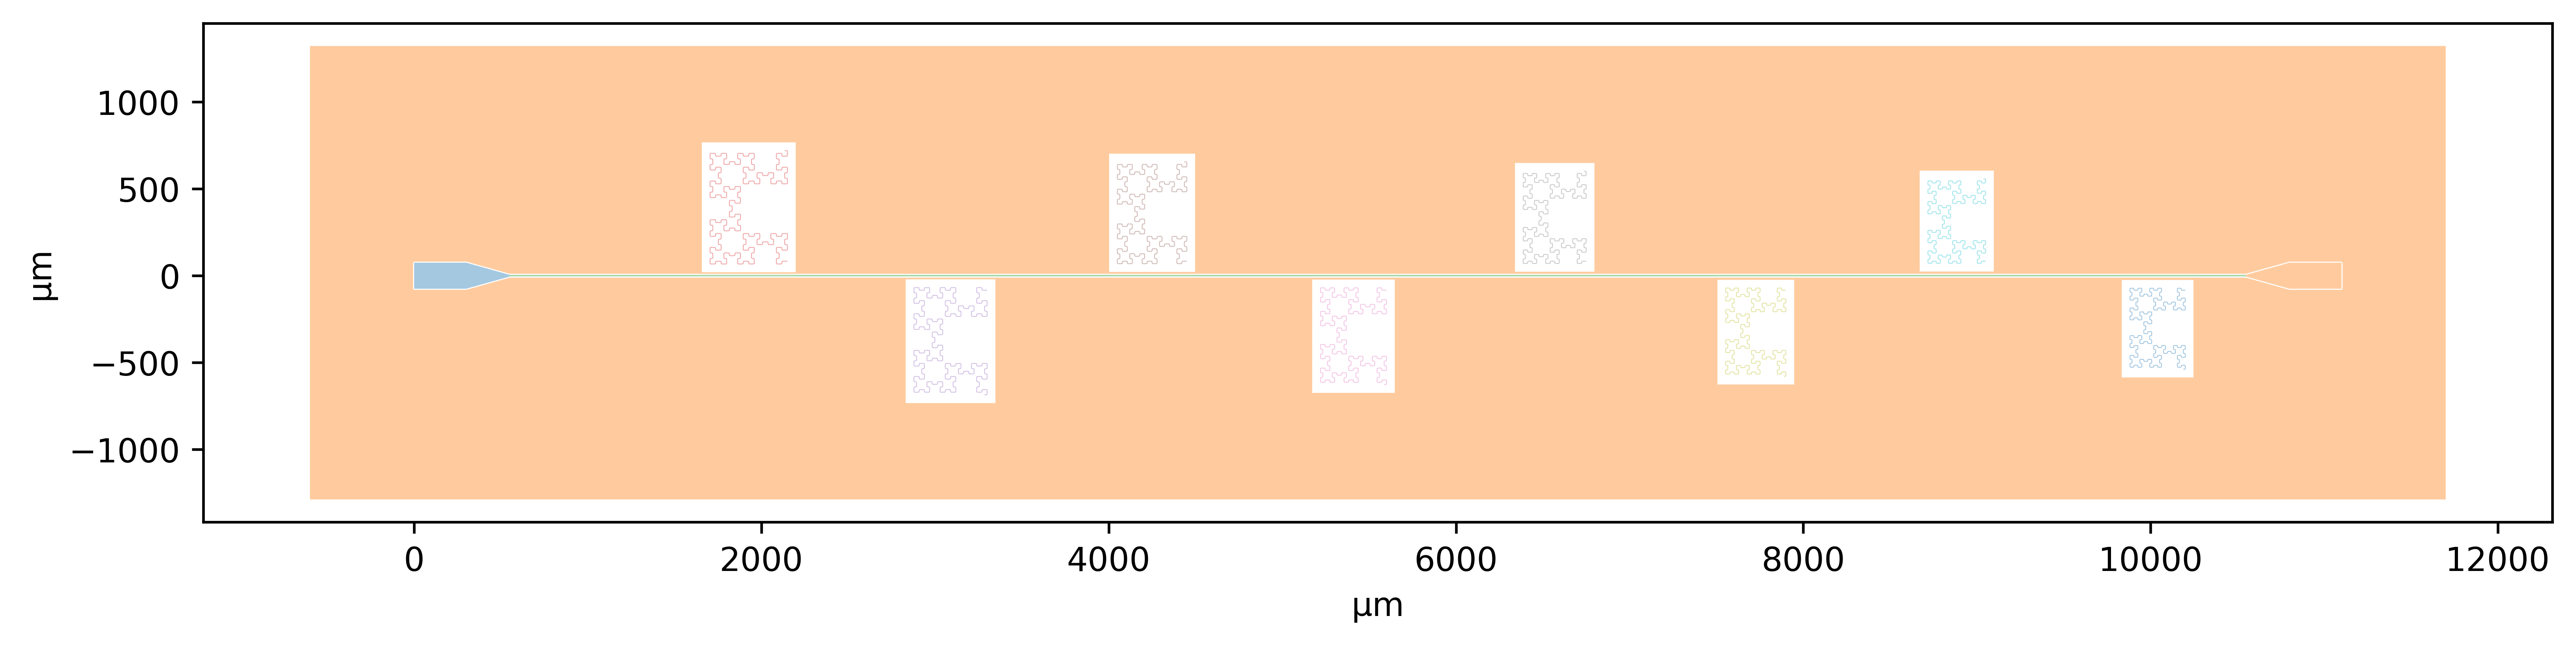


OASIS written to cpw_fibonacci_resonators_v13_square_cavities_with_knobs.oas



In [72]:
# Control Knobs (modify these to adjust fractal fillets and iteration)
# ─────────────────────────────────────────────────────────────
# Number of Fibonacci iterations (higher → more complex fractal)
FIB_ITER = 12  # e.g., set to 8, 9, 10, etc.

# Fillet radius (µm) for rounding each fractal corner
FRACTAL_FILLET_RADIUS = 5.0  # e.g., set to 0 for sharp, up to step length for full radius

# ─────────────────────────────────────────────────────────────
# Remaining imports and code follow below (use FIB_ITER and FRACTAL_FILLET_RADIUS)
# ─────────────────────────────────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

tech = dict(
    # — CPW feed line —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=10000.0,          # µm   distance between launch-pad taper roots

    # — Fibonacci-fractal resonators —
    w_res=5.0,                # µm   resonator trace width
    g_res=6.0,                 # µm   keep-out gap (unused)
    fib_iter=FIB_ITER,         # iterations of Fibonacci word
    d_feed_res=2.0,            # µm   (unused)

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)

    # — Square cavity margin —
    sq_margin=50.0,            # µm   margin around each fractal for square cavity
    fillet_radius=FRACTAL_FILLET_RADIUS,  # µm   radius for filleted cavity corners

    # — Cavity & chip frame —
    cavity_margin=12.0,        # µm   clearance around each resonator for precise cavity
    margin=600.0,              # µm   ground-to-edge clearance
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths for 5 → 7 GHz (8 resonators)
LQ_5GHz = 6000.0                              # µm quarter-wave at 5 GHz in substrate
freqs = np.linspace(5.0, 7.0, 8)              # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs       # µm per resonator

# Build Fibonacci-word with control knob fib_iter
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def fibonacci_word(n: int) -> str:
    a, b = "0", "01"
    for _ in range(n - 1):
        a, b = b, b + a
    return b

_FIB_WORD = fibonacci_word(tech["fib_iter"])
_unit_polyline = [np.array([0.0, 0.0])]
cur_dir = 0
for idx, ch in enumerate(_FIB_WORD):
    if ch == "1":
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
    else:
        cur_dir = (cur_dir + (1 if idx % 2 == 0 else -1)) % 4
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
_unit_polyline = np.asarray(_unit_polyline)
_NUM_MOVES = len(_unit_polyline) - 1
_UNIT_WIDTH = _unit_polyline[:, 0].max() - _unit_polyline[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES

mpl.rcParams["figure.dpi"] = 600

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))

def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]

def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]
    x_feed = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end = x_taper_end + direction * pad_len
    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    return np.column_stack((-pts[:, 1], pts[:, 0]))

def build_fibonacci_resonator(origin, lambda_q, p, upward=True):
    step = lambda_q / _NUM_MOVES
    pts = _unit_polyline * step
    pts = rotate_left_90(pts)
    if not upward:
        pts = pts.copy()
        pts[:, 1] *= -1
    pts += np.asarray(origin) - pts[0]
    fp = gdstk.FlexPath(
        pts.tolist(), p["w_res"], bend_radius=p["fillet_radius"], simple_path=False
    )
    return fp.to_polygons()

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []
    cavities = []

    feed_x0 = p["pad_len"] + p["pad_taper_len"]
    pad_left = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    inset = 400.0
    usable_length = p["feed_len"] - 2 * inset
    pitch = usable_length / len(lambda_quarters)
    start_x = feed_x0 + inset

    for idx, lq in enumerate(lambda_quarters):
        upward = (idx % 2 == 0)
        anchor_x = start_x + idx * pitch + 1200.0
        step = lq / _NUM_MOVES
        y_off = p["w_feed"]/2 + p["g_feed"] + 70.0 + p["w_res"]/2
        anchor_y = y_off if upward else -y_off

        res_polys = build_fibonacci_resonator((anchor_x, anchor_y), lq, p, upward)
        cell.add(*res_polys)
        conductors.extend(res_polys)

        res_union = gdstk.boolean(res_polys, [], "or")
        xs = np.concatenate([poly.points[:, 0] for poly in res_union])
        ys = np.concatenate([poly.points[:, 1] for poly in res_union])
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        sq_min_x = min_x - p["sq_margin"]
        sq_min_y = min_y - p["sq_margin"]
        sq_max_x = max_x + p["sq_margin"]
        sq_max_y = max_y + p["sq_margin"]
        sq_rect = gdstk.rectangle((sq_min_x, sq_min_y), (sq_max_x, sq_max_y))
        filleted_sq = gdstk.offset(sq_rect, -p["fillet_radius"], join="round")
        cavities.extend(filleted_sq)

    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    xs_all = np.concatenate([poly.points[:, 0] for poly in conductors])
    ys_all = np.concatenate([poly.points[:, 1] for poly in conductors])
    frame = rect(xs_all.min() - p["margin"], ys_all.min() - p["margin"], xs_all.max() + p["margin"], ys_all.max() + p["margin"])
    if keepout:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_fibonacci_resonators_v13_square_cavities_with_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")

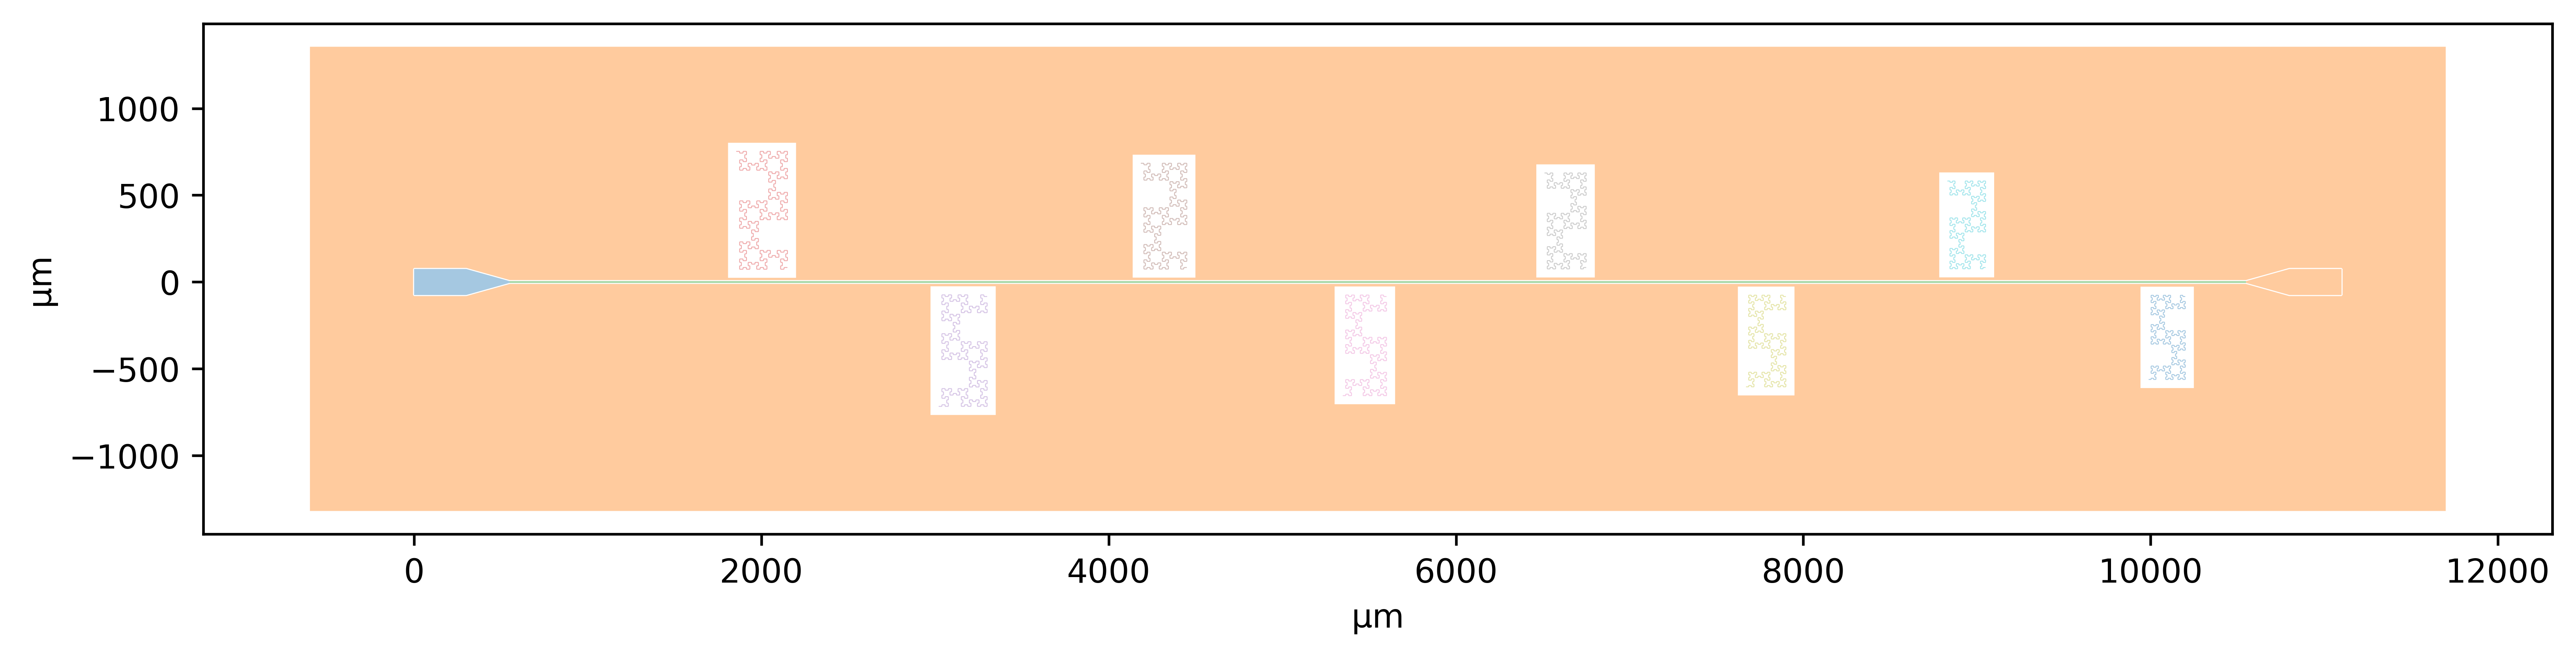


OASIS written to cpw_fibonacci_resonators_v10_square_cavities_with_knobs.oas



In [64]:
# Control Knobs (modify these to adjust fractal fillets and iteration)
# ─────────────────────────────────────────────────────────────
# Number of Fibonacci iterations (higher → more complex fractal)
FIB_ITER = 13  # e.g., set to 8, 9, 10, etc.

# Fillet radius (µm) for rounding each fractal corner
FRACTAL_FILLET_RADIUS = 3.0  # e.g., set to 0 for sharp, up to step length for full radius

# ─────────────────────────────────────────────────────────────
# Remaining imports and code follow below (use FIB_ITER and FRACTAL_FILLET_RADIUS)
# ─────────────────────────────────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

tech = dict(
    # — CPW feed line —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=10000.0,          # µm   distance between launch-pad taper roots

    # — Fibonacci-fractal resonators —
    w_res=5.0,                # µm   resonator trace width
    g_res=6.0,                 # µm   keep-out gap (unused)
    fib_iter=FIB_ITER,         # iterations of Fibonacci word
    d_feed_res=2.0,            # µm   (unused)

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)

    # — Square cavity margin —
    sq_margin=50.0,            # µm   margin around each fractal for square cavity
    fillet_radius=FRACTAL_FILLET_RADIUS,  # µm   radius for filleted cavity corners

    # — Cavity & chip frame —
    cavity_margin=12.0,        # µm   clearance around each resonator for precise cavity
    margin=600.0,              # µm   ground-to-edge clearance
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths for 5 → 7 GHz (8 resonators)
LQ_5GHz = 6000.0                              # µm quarter-wave at 5 GHz in substrate
freqs = np.linspace(5.0, 7.0, 8)              # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs       # µm per resonator

# Build Fibonacci-word with control knob fib_iter
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def fibonacci_word(n: int) -> str:
    a, b = "0", "01"
    for _ in range(n - 1):
        a, b = b, b + a
    return b

_FIB_WORD = fibonacci_word(tech["fib_iter"])
_unit_polyline = [np.array([0.0, 0.0])]
cur_dir = 0
for idx, ch in enumerate(_FIB_WORD):
    if ch == "1":
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
    else:
        cur_dir = (cur_dir + (1 if idx % 2 == 0 else -1)) % 4
        _unit_polyline.append(_unit_polyline[-1] + _DIRECTIONS[cur_dir])
_unit_polyline = np.asarray(_unit_polyline)
_NUM_MOVES = len(_unit_polyline) - 1
_UNIT_WIDTH = _unit_polyline[:, 0].max() - _unit_polyline[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES

mpl.rcParams["figure.dpi"] = 600

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))

def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]

def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]
    x_feed = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end = x_taper_end + direction * pad_len
    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    return np.column_stack((-pts[:, 1], pts[:, 0]))

def build_fibonacci_resonator(origin, lambda_q, p, upward=True):
    step = lambda_q / _NUM_MOVES
    pts = _unit_polyline * step
    pts = rotate_left_90(pts)
    if not upward:
        pts = pts.copy()
        pts[:, 1] *= -1
    pts += np.asarray(origin) - pts[0]
    fp = gdstk.FlexPath(
        pts.tolist(), p["w_res"], bend_radius=p["fillet_radius"], simple_path=False
    )
    return fp.to_polygons()

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []
    cavities = []

    feed_x0 = p["pad_len"] + p["pad_taper_len"]
    pad_left = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    inset = 400.0
    usable_length = p["feed_len"] - 2 * inset
    pitch = usable_length / len(lambda_quarters)
    start_x = feed_x0 + inset

    for idx, lq in enumerate(lambda_quarters):
        upward = (idx % 2 == 0)
        anchor_x = start_x + idx * pitch + 1200.0
        step = lq / _NUM_MOVES
        y_off = p["w_feed"]/2 + p["g_feed"] + 70.0 + p["w_res"]/2
        anchor_y = y_off if upward else -y_off

        res_polys = build_fibonacci_resonator((anchor_x, anchor_y), lq, p, upward)
        cell.add(*res_polys)
        conductors.extend(res_polys)

        res_union = gdstk.boolean(res_polys, [], "or")
        xs = np.concatenate([poly.points[:, 0] for poly in res_union])
        ys = np.concatenate([poly.points[:, 1] for poly in res_union])
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        sq_min_x = min_x - p["sq_margin"]
        sq_min_y = min_y - p["sq_margin"]
        sq_max_x = max_x + p["sq_margin"]
        sq_max_y = max_y + p["sq_margin"]
        sq_rect = gdstk.rectangle((sq_min_x, sq_min_y), (sq_max_x, sq_max_y))
        filleted_sq = gdstk.offset(sq_rect, -p["fillet_radius"], join="round")
        cavities.extend(filleted_sq)

    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    xs_all = np.concatenate([poly.points[:, 0] for poly in conductors])
    ys_all = np.concatenate([poly.points[:, 1] for poly in conductors])
    frame = rect(xs_all.min() - p["margin"], ys_all.min() - p["margin"], xs_all.max() + p["margin"], ys_all.max() + p["margin"])
    if keepout:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_fibonacci_resonators_v10_square_cavities_with_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")